In [83]:
import numpy as np
import librosa
from sklearn import preprocessing


def GenerateFeatures(path, file_name):
    samples, sample_rate = librosa.load(path + '/' + file_name)        
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)  
    S_dB = librosa.power_to_db(S, ref=np.max)
    #mfccs = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40)
    #mfccsmean = np.mean(mfccs.T,axis=0)
    #mfccsmean = -mfccsmean * 100000
    #mfccsscaled = preprocessing.scale(mfccsmean)
    S_dBmean = -np.mean(S_dB.T,axis=0)
    S_dBmean = -S_dBmean * 100000
    S_scaled = preprocessing.scale(S_dBmean)
    
    return S_scaled

In [84]:
import os

recordingsPath = os.getcwd() + '/recordings'

X = []
y = []

for number in range (10):
    fileList = [fn for fn in os.listdir(recordingsPath)
              if fn.startswith(str(number))]
    for index in range(len(fileList)):
        X.append(GenerateFeatures(recordingsPath, fileList[index]))
        y.append(number)

In [85]:
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


# Convert features and corresponding classification labels into numpy arrays
X = np.array(X)
y = np.array(y)

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

random_state = 42 # For convenience and reproducibility in results. Don't do this in production models
#np.random.seed(random_state)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=random_state)#, shuffle=True, stratify=None)


In [89]:
from keras.models import Sequential
from keras.layers import Dense


first_layer_neurons = 50
hidden_layer_neurons = 50

activation_function = 'relu' # 'relu' and 'sigmoid' are two good options.
input_features = len(X[0])
output_features = 10

# Initialize a sequential keras model
model = Sequential(name="Number Classifier")

# Define the layers of the network
input_layer = Dense(first_layer_neurons, input_dim=input_features, activation=activation_function)
hidden_layer = Dense(hidden_layer_neurons, activation=activation_function)
output_layer = Dense(output_features, activation='sigmoid')

# Add the layers to the sequential model. For the exercises, you can try to add and remove layers here. 
model.add(input_layer)
model.add(hidden_layer)
model.add(output_layer)

# Bake the model with a loss function and optimizer. You shouldn't have to change this for the exercises
model.compile(
    # the loss function determines how far "off" the model is when comparing results
    loss='sparse_categorical_crossentropy',
    # The optimizer is in charge of stepping and updating the weights according to the gradient step in learning
    # Don't worry about it too much in this example.
    optimizer='SGD',
    metrics=['accuracy']
)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_53 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_54 (Dense)             (None, 10)                510       
Total params: 9,510
Trainable params: 9,510
Non-trainable params: 0
_________________________________________________________________


Epoch 100 out of 100
Test loss: 0.09
Test accuracy: 96.88%


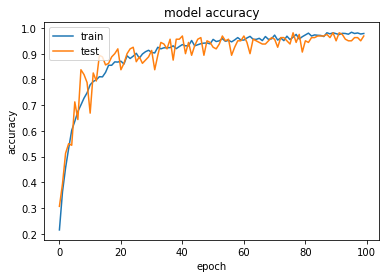

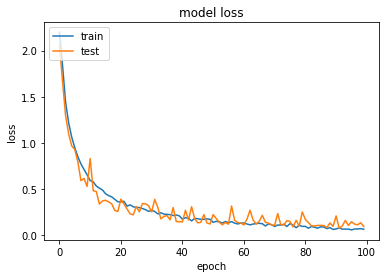

In [90]:
# import plot_helper
%matplotlib inline


# The amount of iterations to train for
max_epochs=100

# This parameter further splits out 30% of the data for validation during training
validation_split = 0.1

plot_callback = plot_helper.PlotCallback(max_epochs)
fitted_model = model.fit(X_train, y_train,
                         batch_size=5,
                         epochs=max_epochs,
                         verbose=0,
                         validation_split=validation_split,
                         callbacks=[plot_callback])    

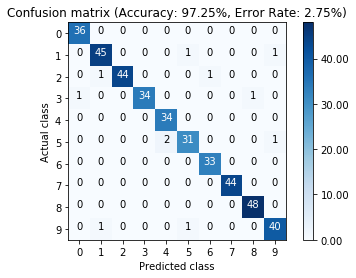

In [91]:
from sklearn.metrics import confusion_matrix

# Get results from model
y_est_test = model.predict(X_test)

# Get the highest probability class for each of the answers
y_est_test = np.argmax(y_est_test, axis=1)

labels = np.array(range(10))
# Build a confusion matrix from the test set and the model results
cm = confusion_matrix(y_test, y_est_test, labels=labels)

plot_helper.plot_confusion_matrix(cm, labels) # This is the same function as in the decision tree example